In [ ]:
#!pip install cloudant

In [ ]:
#!pip install h2o

In [ ]:
#!pip install scikit-learn --upgrade

In [ ]:
#!pip install lightgbm --upgrade

In [ ]:
#!pip install xgboost --upgrade

In [ ]:
#!pip install imblearn --upgrade

In [ ]:
#!pip install holidays

In [1]:
# Import de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date
from datetime import timedelta
import holidays

from sklearn.impute import SimpleImputer
from cloudant import Cloudant

from sklearn.model_selection import train_test_split

# Import dos módulos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Verificando se existem registros duplicados no dataset
def verify_dup_rows(data):
    
    print("Linhas do dataset até o momento:")
    print(data.shape)

    # Obtendo somente linhas duplicadas
    tmp = data[data.duplicated()]

    print("\nLinhas duplicadas até o momento:")
    print(tmp.shape)
    
    del tmp
    
    
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('\nÓtimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df):
    
    df.dropna(axis='index', how='any', subset=['Tempo', 'Estação', 'LAT', 'LONG', 
                                               'Movimentação', 'Original_473', 
                                               'Original_269', 'Zero', 'Maçã-Verde', 
                                               'Tangerina', 'Citrus', 'Açaí-Guaraná', 
                                               'Pêssego'])

    # coloca constante 0 em outras colunas com dados missing
    impute_zeros = SimpleImputer(
                                    missing_values=np.nan,
                                    strategy='constant',
                                    fill_value=0,
                                    verbose=0,
                                    copy=True
                                )
    
    impute_zeros.fit(X=df)

    # Reconstruindo um Pandas DataFrame com os resultados
    data = pd.DataFrame.from_records(
            data = impute_zeros.transform(
            X    = df
        ),
        columns=df.columns
    )    
    
    # Converte colunas para numerico
    data = data.apply(pd.to_numeric, errors='ignore')

    return data

# Funcao para trabalhar as features
def feature_engineering(df, treino=True):

    if treino:
        
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')

        # Removendo colunas unicas
        df = df.drop(['_id', '_rev', 'row'], axis = 1)

        # Verificar os registros duplicados
        verify_dup_rows(df)

        # Removendo colunas unicas
        df = df.drop(['Tempo','Estação','Movimentação','LAT','LONG'], axis = 1)

        # Removendo registros duplicados
        df = df.drop_duplicates().reset_index(drop=True)

        # Renomeando colunas apenas para funcionar alguns algoritmos
        df = df.rename(columns={"Maçã-Verde": "Maca_Verde", "Açaí-Guaraná":"Acai_Guarana", "Pêssego":"Pessego"})        
    
    else:
        # Corrige dados incorretos
        df.loc[df.index == 89, 'Tempo'] = "2019-02-28 01:00:00"
        df.loc[df.index == 90, 'Tempo'] = "2019-02-28 02:00:00"

        df.loc[df.index == 449, 'Tempo'] = "2018-02-28 01:00:00"
        df.loc[df.index == 450, 'Tempo'] = "2018-02-28 02:00:00"

        df.loc[df.index == 809, 'Tempo'] = "2019-02-28 01:00:00"
        df.loc[df.index == 810, 'Tempo'] = "2019-02-28 02:00:00"
        
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')
        
        # Removendo colunas unicas
        df = df.drop(['Tempo','Estação','Movimentação','LAT','LONG'], axis = 1)

        # Renomeando colunas apenas para funcionar alguns algoritmos
        df = df.rename(columns={"Maçã-Verde": "Maca_Verde", "Açaí-Guaraná":"Acai_Guarana", "Pêssego":"Pessego"})        

    return df

# Funcao para transformar features categoricas em numericas
def fe_cat_num(df):

    # Tratando variáveis categóricas com o método Pandas ``get_dummies()''
    df = pd.get_dummies(df, columns=['Estação'])

    return df    

In [3]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
train = pd.read_csv(r'desafio_7_treino.csv')

# Feature Engineering
treino = preenche_missing(train)    
treino = feature_engineering(treino, True) 

# Verificando as colunas com dados missing do dataset
check_missing(treino, display = 15)

print('\nLinhas unicas até o momento:')
print(treino.shape)

Linhas do dataset até o momento:
(91928, 14)

Linhas duplicadas até o momento:
(74952, 14)

Ótimo! Não há mais valores faltantes neste dataset.

Linhas unicas até o momento:
(16953, 9)


In [4]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16953 entries, 0 to 16952
Data columns (total 9 columns):
Original_473    16953 non-null int64
Original_269    16953 non-null int64
Zero            16953 non-null int64
Maca_Verde      16953 non-null int64
Tangerina       16953 non-null int64
Citrus          16953 non-null int64
Acai_Guarana    16953 non-null int64
Pessego         16953 non-null int64
TARGET          16953 non-null object
dtypes: int64(8), object(1)
memory usage: 1.2+ MB


,TARGET,%
NORMAL,11467,67.64
REABASTECER,5486,32.36


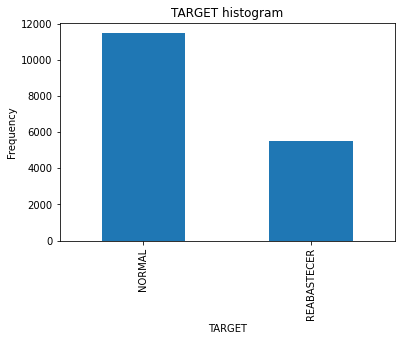

In [5]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [6]:
# Selecionando feature target
y = treino['TARGET']

# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

# MODELAGEM SEM SMOTE

In [ ]:
TESTE_SIZE  = 0.2
RANDOM_SEED = 133

In [7]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TESTE_SIZE, random_state=RANDOM_SEED)

In [8]:
# Treinamento com DecisionTreeClassifier
model_dtc = DecisionTreeClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_dtc.predict(X_valid)

# Salvando o score
dtc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.82      0.79      0.81      2298
 REABASTECER       0.59      0.63      0.61      1093

    accuracy                           0.74      3391
   macro avg       0.70      0.71      0.71      3391
weighted avg       0.74      0.74      0.74      3391

F1_macro   :  0.7068230741180761
F1_micro   :  0.7398997345915659
F1_weighted:  0.7418163804135591
F1_none    :  [0.80529801 0.60834813]


In [9]:
# Treinamento com GradientBoosting
model_gbc = GradientBoostingClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_gbc.predict(X_valid)

# Salvando o score
gbc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.77      0.86      0.81      2298
 REABASTECER       0.60      0.45      0.52      1093

    accuracy                           0.73      3391
   macro avg       0.69      0.66      0.66      3391
weighted avg       0.71      0.73      0.72      3391

F1_macro   :  0.6644430735256112
F1_micro   :  0.7281038041875553
F1_weighted:  0.7163802302267911
F1_none    :  [0.81059984 0.51828631]


In [10]:
# Treinamento com RandomForestClassifier
model_rfc = RandomForestClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_rfc.predict(X_valid)

# Salvando o score
rfc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.88      0.73      0.80      2298
 REABASTECER       0.58      0.79      0.67      1093

    accuracy                           0.75      3391
   macro avg       0.73      0.76      0.74      3391
weighted avg       0.78      0.75      0.76      3391

F1_macro   :  0.7356878202310282
F1_micro   :  0.751105868475376
F1_weighted:  0.7583724943878526
F1_none    :  [0.79952494 0.6718507 ]


In [11]:
# Treinamento com XGBClassifier
model_xgb = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.84      0.77      0.80      2298
 REABASTECER       0.59      0.70      0.64      1093

    accuracy                           0.75      3391
   macro avg       0.72      0.73      0.72      3391
weighted avg       0.76      0.75      0.75      3391

F1_macro   :  0.7214741980600302
F1_micro   :  0.7455028015334709
F1_weighted:  0.7505449482462712
F1_none    :  [0.80328243 0.63966597]


In [12]:
# Treinamento com LGBMClassifier
model_lgb = LGBMClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_lgb.predict(X_valid)

# Salvando o score
lgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.90      0.72      0.80      2298
 REABASTECER       0.58      0.84      0.69      1093

    accuracy                           0.76      3391
   macro avg       0.74      0.78      0.74      3391
weighted avg       0.80      0.76      0.76      3391

F1_macro   :  0.7432371137331147
F1_micro   :  0.7552344441167798
F1_weighted:  0.7629598737772025
F1_none    :  [0.79873909 0.68773514]


In [13]:
# Prepara a lista de resultados
metricas = [(gbc_score),(dtc_score),(rfc_score),(xgb_score),(lgb_score)]

# Cria o dataframe
df_metricas = pd.DataFrame(metricas, 
                           columns = ['Accuracy'], 
                           index = ['GBC', 'DTC', 'RFC', 'XGB', 'LGB']) 

# Visualiza o resultado
df_metricas

,Accuracy
GBC,0.716380
DTC,0.741816
RFC,0.758372
XGB,0.750545
LGB,0.762960


# MODELAGEM COM SMOTE

In [14]:
# Import dos módulos
from imblearn.over_sampling import SMOTE

# Aplicando a funcao SMOTE
sm = SMOTE(random_state=RANDOM_SEED)
_X, _y = sm.fit_sample(X, y)

Using TensorFlow backend.


In [15]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=TESTE_SIZE, random_state=RANDOM_SEED)

In [16]:
# Treinamento com DecisionTreeClassifier
model_dtc = DecisionTreeClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_dtc.predict(X_valid)

# Salvando o score
dtc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.80      0.77      0.79      2339
 REABASTECER       0.77      0.80      0.79      2248

    accuracy                           0.79      4587
   macro avg       0.79      0.79      0.79      4587
weighted avg       0.79      0.79      0.79      4587

F1_macro   :  0.7887507773674329
F1_micro   :  0.788750817527796
F1_weighted:  0.7887526046639531
F1_none    :  [0.78884289 0.78865867]


In [17]:
# Treinamento com GradientBoosting
model_gbc = GradientBoostingClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_gbc.predict(X_valid)

# Salvando o score
gbc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.97      0.69      0.80      2339
 REABASTECER       0.75      0.97      0.85      2248

    accuracy                           0.83      4587
   macro avg       0.86      0.83      0.82      4587
weighted avg       0.86      0.83      0.82      4587

F1_macro   :  0.8247148616491606
F1_micro   :  0.8275561369086549
F1_weighted:  0.8242721286892052
F1_none    :  [0.8023982  0.84703152]


In [18]:
# Treinamento com RandomForestClassifier
model_rfc = RandomForestClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_rfc.predict(X_valid)

# Salvando o score
rfc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.96      0.70      0.81      2339
 REABASTECER       0.76      0.97      0.85      2248

    accuracy                           0.83      4587
   macro avg       0.86      0.84      0.83      4587
weighted avg       0.86      0.83      0.83      4587

F1_macro   :  0.8315349494849789
F1_micro   :  0.8338783518639634
F1_weighted:  0.831140772744706
F1_none    :  [0.81166584 0.85140406]


In [19]:
# Treinamento com XGBClassifier
model_xgb = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.90      0.73      0.81      2339
 REABASTECER       0.77      0.91      0.83      2248

    accuracy                           0.82      4587
   macro avg       0.83      0.82      0.82      4587
weighted avg       0.83      0.82      0.82      4587

F1_macro   :  0.8200153845381807
F1_micro   :  0.8210159145410943
F1_weighted:  0.8197491616426685
F1_none    :  [0.806596   0.83343477]


In [20]:
# Treinamento com LGBMClassifier
model_lgb = LGBMClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_lgb.predict(X_valid)

# Salvando o score
lgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.96      0.70      0.81      2339
 REABASTECER       0.75      0.97      0.85      2248

    accuracy                           0.83      4587
   macro avg       0.86      0.83      0.83      4587
weighted avg       0.86      0.83      0.83      4587

F1_macro   :  0.8293915757984931
F1_micro   :  0.8319162851536952
F1_weighted:  0.8289798400434332
F1_none    :  [0.80863738 0.85014577]


In [21]:
# Prepara a lista de resultados
metricas = [(gbc_score),(dtc_score),(rfc_score),(xgb_score),(lgb_score)]

# Cria o dataframe
df_metricas = pd.DataFrame(metricas, 
                           columns = ['Accuracy'], 
                           index = ['GBC', 'DTC', 'RFC', 'XGB', 'LGB']) 

# Visualiza o resultado
df_metricas

,Accuracy
GBC,0.824272
DTC,0.788753
RFC,0.831141
XGB,0.819749
LGB,0.828980
